In [17]:
from binance.client import Client

import ccxt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap

from sklearn.preprocessing import MinMaxScaler

# Correlation Matrix

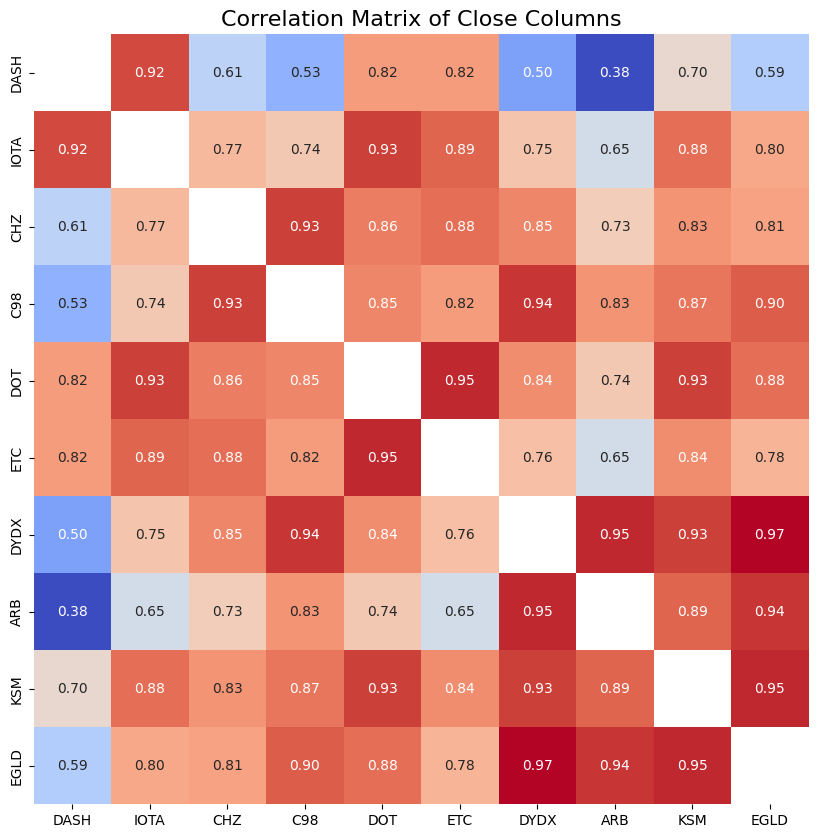

In [2]:
'''
현물
분봉/일봉 조회
fetch_ohlcv 메소드를 사용하면 특정 암호화폐의 분봉/일봉 데이터를 500개까지 얻을 수 있습니다. fetch_ohlcv 메소드는 2차원 리스트 형태로 데이터를 제공해주므로 이를 판다스의 데이터프레임으로 변환하여 사용하면 편리합니다. 바이낸스 거래소의 기준 시간은 UTC이므로 국내보다 약 9시간 느린 것을 확인할 수 있습니다.
input parameters
    symbol    : BTC/USDT ... 같은 토큰 2개의 쌍
    timeframe : 1m(분봉), 1d(일봉) ==> 기본 일봉
    limit     : 조회 건수 ==> 기본 500
'''
pd.set_option('future.no_silent_downcasting', True)
def binance_getch_ohlcv(symbol, timeframe='1m', limit = 365):
    binance = ccxt.binance()
    
    try:
        get_ohlcv = binance.fetch_ohlcv(symbol=symbol, timeframe=timeframe, limit=limit)

        df = pd.DataFrame(get_ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit="ms")
        df.set_index('datetime', inplace=True)
        
    except:
        # 오늘 날짜 기준으로 limit만큼 과거 날짜 생성
        start_date = datetime.today() - timedelta(days=limit - 1)
        dates = [start_date + timedelta(days=i) for i in range(limit)]
        df = pd.DataFrame(np.nan, index = dates, columns=['close'])
        
        df.index = df.index.strftime('%Y/%m/%d')
        df.index.name = 'datetime'
        
    return df

'''
Function    : cctx_line_func
Description : 두 코인의 기간 내의 변화 추이 시각화를 위한 라인 차트
Parameter   :
                target : 분석하고자 하는 타겟 리스트
                limit  : 분석하고자 하는 기준(일일 기준)
'''
def cctx_line_func(target, limit):
    # 데이터프레임 딕셔너리 생성
    dataframes = {}
    
    # 타겟 코인 관련 정보 얻기
    for name in target:
        df = binance_getch_ohlcv(f"{name}/USDT", timeframe="1d", limit = limit)
        key = name
        dataframes[key] = df['close']

    # 상관계수 계산 및 테이블 화
    correlation_matrix = pd.DataFrame(index=dataframes.keys(), columns=dataframes.keys())

    for key1 in dataframes.keys():
        for key2 in dataframes.keys():
            if dataframes[key1].isnull().all() or dataframes[key2].isnull().all():
                # 하나라도 모든 값이 NaN이면 'error'로 설정
                correlation_matrix.loc[key1, key2] = np.nan
            else:
                # 상관계수 계산
                if key1 == key2:
                    correlation_matrix.loc[key1, key2] = np.nan  # 빈칸 처리
                else:
                    corr = dataframes[key1].corr(dataframes[key2])
                    correlation_matrix.loc[key1, key2] = round(corr, 2)
                    
   
    
    print(correlation_matrix)
    # 히트맵 시각화
    plt.figure(figsize=(10, 10))
    # sns.heatmap(numeric_matrix, annot=correlation_matrix, cmap='coolwarm', fmt='.2f', cbar=False)
    sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f',
            cbar=False)  # 모든 텍스트 색))   # NaN 위치의 배경색
    
    plt.title('Correlation Matrix of Close Columns', fontsize=16)
    plt.show()
    
    
# target 코인(USDT 기준) 예시, 추후에도 리스트로 입력한다면 무관
target = ['DASH','IOTA','sample']

# Default 365, 필요에 따라 180(6개월), 90(3개월) 선택 가능하도록 기능
limit = 5

# target 코인 관련 정보 csv 저장
cctx_line_func(target, limit)

# Line Chart

/tmp/ipykernel_578430/3155227772.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')  # 10가지 색상 제공 (다른 컬러맵도 사용 가능)


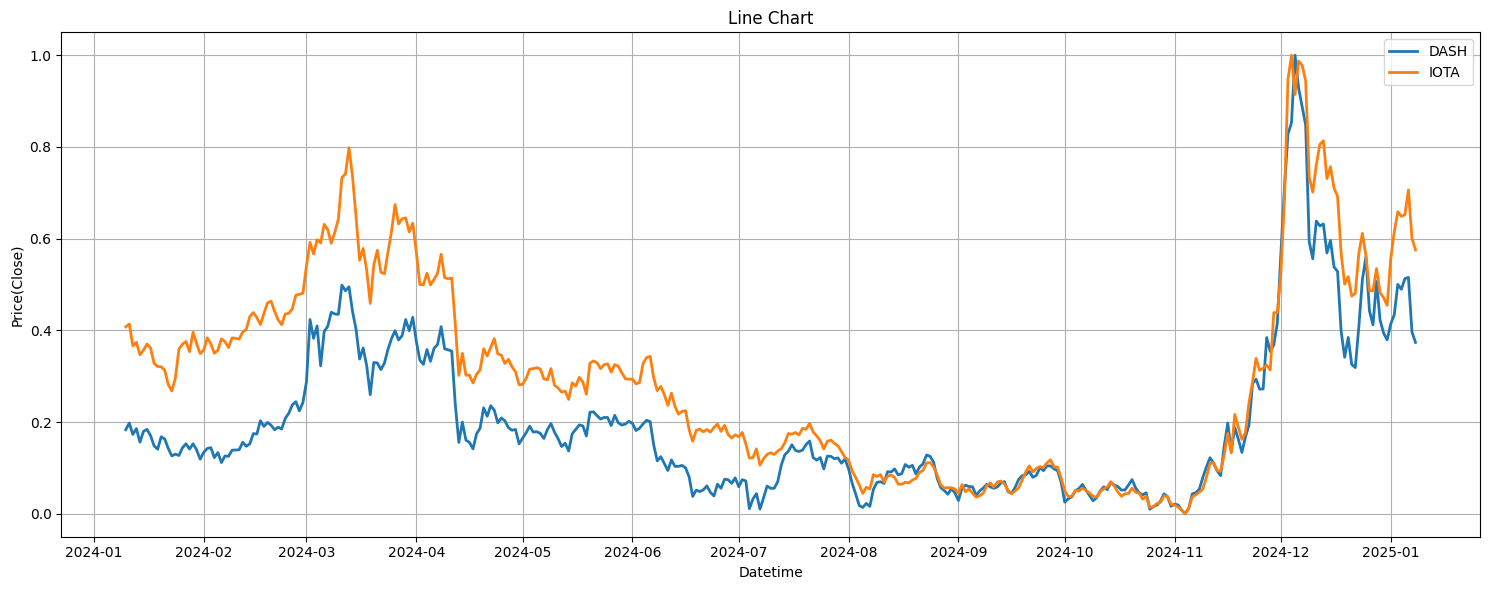

In [ ]:
def binance_getch_ohlcv(symbol, timeframe='1m', limit = 365):
    binance = ccxt.binance()
    
    try:
        get_ohlcv = binance.fetch_ohlcv(symbol=symbol, timeframe=timeframe, limit=limit)
        df = pd.DataFrame(get_ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit="ms")
        
        scaler = MinMaxScaler()
        df['close'] = scaler.fit_transform(df[['close']])
        
    except:
        # 오늘 날짜 기준으로 limit만큼 과거 날짜 생성
        print(f'{symbol} is not existed!')
        start_date = datetime.today() - timedelta(days=limit - 1)
        dates = [start_date + timedelta(days=i) for i in range(limit)]
        # NaN으로 채워진 데이터프레임 생성 (datetime을 인덱스)
        df = pd.DataFrame({'datetime': dates, 'close': np.nan})
        df['datetime'] = df['datetime'].dt.strftime('%Y/%m/%d')
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        
    return df

'''
Function    : cctx_line_func
Description : 두 코인의 기간 내의 변화 추이 시각화를 위한 라인 차트
Parameter   :
                target : 분석하고자 하는 타겟 리스트
                limit  : 분석하고자 하는 기준(일일 기준)
'''


def cctx_line_func(target, limit):
    # 컬러맵 설정
    cmap = get_cmap('tab10')  # 10가지 색상 제공 (다른 컬러맵도 사용 가능)
    plt.figure(figsize=(15, 6))    
    
    # 타겟 코인 관련 정보 얻기
    for i, name in enumerate(target):
        df = binance_getch_ohlcv(f"{name}/USDT", timeframe="1d", limit = limit)
        plt.plot(df['datetime'], df['close'], color=cmap(i), label=f'{name}', linestyle='-', linewidth=2)

    # x축 레이블 포맷 설정
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 1개월 간격으로 레이블 표시
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 레이블 형식: YYYY-MM

    # 히트맵 시각화
    # 그래프 설정
    plt.title('Line Chart')
    plt.xlabel('Datetime')
    plt.ylabel('Price(Close)')
    plt.legend()
    plt.grid()

    # x축 레이블 숨기기
    # plt.gca().xaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    
# target 코인(USDT 기준) 예시, 추후에도 리스트로 입력한다면 무관
target = ['DASH','IOTA']

# Default 365, 필요에 따라 180(6개월), 90(3개월) 선택 가능하도록 기능
limit = 365

# target 코인 관련 정보 csv 저장
cctx_line_func(target, limit)